In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
with open('data/new_files/get_movies.pkl', 'rb') as f:
    t = pickle.load(f)
    
movie_dic = t[0]
movie_genre_dic = t[1]

with open('data/new_files/get_ratings.pkl', 'rb') as f:
    lst = pickle.load(f)

In [3]:
def grad_U(Ui, Yij, Vj, y_mean, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return (1-2*reg*eta)*Ui + 2 * eta * Vj * (Yij - y_mean - np.dot(Ui,Vj))     

def grad_V(Vj, Yij, Ui, y_mean, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return (1-2*reg*eta)*Vj + 2 * eta * Ui * (Yij - y_mean - np.dot(Ui,Vj))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    
    y_mean = np.mean(np.array([tup[2] for tup in Y]))
    
    # Compute mean squared error on each data point in Y; include
    # regularization penalty in error calculations.
    # We first compute the total squared squared error
    err = 0.0
    for (i,j,Yij) in Y:
        err += (Yij - y_mean - np.dot(U[i-1], V[:,j-1]))**2
    # Add error penalty due to regularization if regularization
    # parameter is nonzero
    if reg != 0:
        U_frobenius_norm = np.linalg.norm(U, ord='fro')
        V_frobenius_norm = np.linalg.norm(V, ord='fro')
        err += reg * (U_frobenius_norm ** 2)
        err += reg * (V_frobenius_norm ** 2)
    # Return the mean of the regularized error
    return err / float(len(Y))

def get_msqe_err(U, V, Y):
    y_mean = np.mean(np.array([tup[2] for tup in Y]))
    
    err = 0.0
    for (i,j,Yij) in Y:
        err += (Yij - y_mean - np.dot(U[i-1], V[:,j-1]))**2
    
    err /= len(Y)
    
    return err ** 0.5

def train_model(M, N, K, eta, reg, Y, Y_test):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    
    y_mean = np.mean(np.array([tup[2] for tup in Y]))
    
    # Initialize U, V  
    U = np.random.random((M,K)) - 0.5
    V = np.random.random((K,N)) - 0.5
    
    best_test_error = float('inf')
    
    size = len(Y)
    delta = None
    indices = np.arange(size)    
    epoch = 0

    
    while epoch < 301:
        epoch += 1
        
        # Run an epoch of SGD
        before_E_in = get_err(U, V, Y, reg)
        np.random.shuffle(indices)
        
        prev_U = U.copy()
        prev_V = V.copy()
        
        for ind in indices:
            (i,j, Yij) = Y[ind]
            # Update U[i], V[j]
            U[i-1] = grad_U(U[i-1], Yij, V[:,j-1], y_mean, reg, eta)
            V[:,j-1] = grad_V(V[:,j-1], Yij, U[i-1], y_mean, reg, eta);
        # At end of epoch, print E_in
        E_in = get_err(U, V, Y, reg)
        E_out = get_msqe_err(U, V, Y_test)

        print("Epoch %s, E_in (regularized MSE): %s; E_out (MSQE): %s"%(epoch, E_in, E_out))


        if best_test_error > E_out:
            best_test_error = E_out
        else:
            return (prev_U, prev_V, get_msqe_err(prev_U, prev_V, Y), get_msqe_err(prev_U, prev_V, Y_test), epoch - 1)

    return -1

In [4]:
ratings = np.array(lst)

# train/test

In [5]:
Y_train = np.loadtxt('data/new_files/train.txt').astype(int)
Y_test = np.loadtxt('data/new_files/test.txt').astype(int)

In [6]:
num_movies = len(movie_dic)
num_users = 943
m = num_users
n = num_movies
k = 20

etas = [0.01, 0.012, 0.008, 0.014, 0.006, 0.016, 0.004, 0.018, 0.002, 0.02, 0.001]
regs = [0.1, 0.12, 0.08, 0.14, 0.06, 0.16, 0.04, 0.18, 0.02, 0.2, 0.01]

best_pair = (1, 0.001)
best_e_out = float('inf')

for eta in etas:
    for reg in regs:
        u,v, final_err, final_test_err, epoch = train_model(m, n, k, eta, reg, Y_train, Y_test)
        
        print(eta, reg, final_test_err)
        
        if best_e_out > final_test_err:
            best_pair = (eta, reg)
            best_e_out = final_test_err
            
            print("new record")
        
        with open("matrices/normal_eta_{}_reg_{}_epoch_{}_testerr_{}.matrix".format(eta, reg, epoch, final_test_err), "wb+") as f:
            np.save(f, v)

print("Best (eta, reg) pair: ", best_pair)


u,v, final_err, final_test_err, epoch = train_model(m, n, k, best_pair[0], best_pair[1], Y_train, Y_test)

print(final_test_err, epoch)

Epoch 1, E_in (regularized MSE): 1.2214939359555828; E_out (MSQE): 1.1326221013681446
Epoch 2, E_in (regularized MSE): 1.1298249698314444; E_out (MSQE): 1.1039612643905519
Epoch 3, E_in (regularized MSE): 0.9938381704955194; E_out (MSQE): 1.0540227734549394
Epoch 4, E_in (regularized MSE): 0.8842334671923022; E_out (MSQE): 1.013797510183615
Epoch 5, E_in (regularized MSE): 0.8149391835901144; E_out (MSQE): 0.9882261901317445
Epoch 6, E_in (regularized MSE): 0.7697256534262615; E_out (MSQE): 0.972679724635447
Epoch 7, E_in (regularized MSE): 0.7392221248194373; E_out (MSQE): 0.9636550739897596
Epoch 8, E_in (regularized MSE): 0.7157734895372858; E_out (MSQE): 0.9553765870614997
Epoch 9, E_in (regularized MSE): 0.6970377452729769; E_out (MSQE): 0.9500730184597814
Epoch 10, E_in (regularized MSE): 0.6818252595393371; E_out (MSQE): 0.9466587979141433
Epoch 11, E_in (regularized MSE): 0.6678393517359598; E_out (MSQE): 0.9419852877905618
Epoch 12, E_in (regularized MSE): 0.6548662458187726; 

Epoch 12, E_in (regularized MSE): 0.5433351640641066; E_out (MSQE): 0.9546301564427427
Epoch 13, E_in (regularized MSE): 0.5294992835216153; E_out (MSQE): 0.953982709305056
Epoch 14, E_in (regularized MSE): 0.5187197623670629; E_out (MSQE): 0.9538212351224961
Epoch 15, E_in (regularized MSE): 0.50730207579005; E_out (MSQE): 0.9532350524893878
Epoch 16, E_in (regularized MSE): 0.4989924415966766; E_out (MSQE): 0.9534279361035707
0.01 0.06 0.9532350524893878
Epoch 1, E_in (regularized MSE): 1.2210616766915063; E_out (MSQE): 1.1275636534187465
Epoch 2, E_in (regularized MSE): 1.154615118465784; E_out (MSQE): 1.1032581512327262
Epoch 3, E_in (regularized MSE): 1.0566353711296428; E_out (MSQE): 1.0644155016585255
Epoch 4, E_in (regularized MSE): 0.9743755160930859; E_out (MSQE): 1.03167778464115
Epoch 5, E_in (regularized MSE): 0.9170389067418078; E_out (MSQE): 1.0092881212832456
Epoch 6, E_in (regularized MSE): 0.8804736573981584; E_out (MSQE): 0.9940658669112745
Epoch 7, E_in (regularized

Epoch 22, E_in (regularized MSE): 0.8338447638178081; E_out (MSQE): 0.9636714330247498
0.01 0.2 0.9627595263116556
Epoch 1, E_in (regularized MSE): 1.2093196971743454; E_out (MSQE): 1.1486444201381394
Epoch 2, E_in (regularized MSE): 1.035157391544389; E_out (MSQE): 1.1084118809142716
Epoch 3, E_in (regularized MSE): 0.8429523055040213; E_out (MSQE): 1.0572598364369123
Epoch 4, E_in (regularized MSE): 0.7189732500907957; E_out (MSQE): 1.0278325941445503
Epoch 5, E_in (regularized MSE): 0.6430821628009337; E_out (MSQE): 1.0161502707043764
Epoch 6, E_in (regularized MSE): 0.5905511647380894; E_out (MSQE): 1.0121223436668454
Epoch 7, E_in (regularized MSE): 0.5513242480573041; E_out (MSQE): 1.0108446263908275
Epoch 8, E_in (regularized MSE): 0.5205560667637946; E_out (MSQE): 1.0137255897805078
0.01 0.01 1.0108446263908275
Epoch 1, E_in (regularized MSE): 1.1996425382018931; E_out (MSQE): 1.127224443339807
Epoch 2, E_in (regularized MSE): 1.065398415646116; E_out (MSQE): 1.0808618644758734

Epoch 9, E_in (regularized MSE): 0.55592621083395; E_out (MSQE): 0.9501275031273053
Epoch 10, E_in (regularized MSE): 0.5370430157609387; E_out (MSQE): 0.9494741517707963
Epoch 11, E_in (regularized MSE): 0.5215473683644777; E_out (MSQE): 0.9474874756894629
Epoch 12, E_in (regularized MSE): 0.509230312048602; E_out (MSQE): 0.9484525982629906
0.012 0.06 0.9474874756894629
Epoch 1, E_in (regularized MSE): 1.217560945879271; E_out (MSQE): 1.1255248823458188
Epoch 2, E_in (regularized MSE): 1.1464229332330307; E_out (MSQE): 1.096667684095076
Epoch 3, E_in (regularized MSE): 1.0297790213508484; E_out (MSQE): 1.04945316447958
Epoch 4, E_in (regularized MSE): 0.9411783536452888; E_out (MSQE): 1.013304923890553
Epoch 5, E_in (regularized MSE): 0.8855354035084626; E_out (MSQE): 0.9914256951049184
Epoch 6, E_in (regularized MSE): 0.8479734095722606; E_out (MSQE): 0.9773385195053411
Epoch 7, E_in (regularized MSE): 0.8274052806093307; E_out (MSQE): 0.9695773972468161
Epoch 8, E_in (regularized MS

Epoch 9, E_in (regularized MSE): 0.7336225147157397; E_out (MSQE): 0.9625198919538028
Epoch 10, E_in (regularized MSE): 0.7145408775939297; E_out (MSQE): 0.9567049494495431
Epoch 11, E_in (regularized MSE): 0.6986308768150477; E_out (MSQE): 0.9523578545242648
Epoch 12, E_in (regularized MSE): 0.6833720441532408; E_out (MSQE): 0.9490320400700166
Epoch 13, E_in (regularized MSE): 0.6713666891265032; E_out (MSQE): 0.9462174057992364
Epoch 14, E_in (regularized MSE): 0.6606020994304599; E_out (MSQE): 0.9439380693351674
Epoch 15, E_in (regularized MSE): 0.6505021620757657; E_out (MSQE): 0.94152879553172
Epoch 16, E_in (regularized MSE): 0.6415403858463644; E_out (MSQE): 0.9396561340680025
Epoch 17, E_in (regularized MSE): 0.633398050733802; E_out (MSQE): 0.9385173821932749
Epoch 18, E_in (regularized MSE): 0.6255538508231802; E_out (MSQE): 0.9368337858389554
Epoch 19, E_in (regularized MSE): 0.6180803382720695; E_out (MSQE): 0.9358130054438791
Epoch 20, E_in (regularized MSE): 0.61204960905

Epoch 24, E_in (regularized MSE): 0.7094496350876891; E_out (MSQE): 0.939625216678384
Epoch 25, E_in (regularized MSE): 0.7074485043976965; E_out (MSQE): 0.9394825058174967
Epoch 26, E_in (regularized MSE): 0.7043755155009248; E_out (MSQE): 0.9388919217252709
Epoch 27, E_in (regularized MSE): 0.70105557983102; E_out (MSQE): 0.9373505072887012
Epoch 28, E_in (regularized MSE): 0.6975021505507647; E_out (MSQE): 0.9371213054909244
Epoch 29, E_in (regularized MSE): 0.6967335561183853; E_out (MSQE): 0.937735294121379
0.008 0.14 0.9371213054909244
Epoch 1, E_in (regularized MSE): 1.2346544855624721; E_out (MSQE): 1.141720725083455
Epoch 2, E_in (regularized MSE): 1.1401201888946955; E_out (MSQE): 1.1180544145313756
Epoch 3, E_in (regularized MSE): 1.0092888417968509; E_out (MSQE): 1.0754358911375945
Epoch 4, E_in (regularized MSE): 0.886594052206589; E_out (MSQE): 1.03452778711433
Epoch 5, E_in (regularized MSE): 0.7983701933971146; E_out (MSQE): 1.0070707321716346
Epoch 6, E_in (regularized

Epoch 7, E_in (regularized MSE): 0.617305995826351; E_out (MSQE): 0.9950032902583971
Epoch 8, E_in (regularized MSE): 0.5824044612849639; E_out (MSQE): 0.9923123148719399
Epoch 9, E_in (regularized MSE): 0.5541235960331136; E_out (MSQE): 0.9925413715467978
0.008 0.02 0.9923123148719399
Epoch 1, E_in (regularized MSE): 1.2424937932334876; E_out (MSQE): 1.1308578714602127
Epoch 2, E_in (regularized MSE): 1.2148771725582665; E_out (MSQE): 1.119803513165979
Epoch 3, E_in (regularized MSE): 1.1831432910181126; E_out (MSQE): 1.1061280330393237
Epoch 4, E_in (regularized MSE): 1.1268757105839107; E_out (MSQE): 1.0829486236635426
Epoch 5, E_in (regularized MSE): 1.0588496683149804; E_out (MSQE): 1.0547758099127231
Epoch 6, E_in (regularized MSE): 1.0031711537789536; E_out (MSQE): 1.0317746509024386
Epoch 7, E_in (regularized MSE): 0.962786811969176; E_out (MSQE): 1.0157007543455634
Epoch 8, E_in (regularized MSE): 0.934804637751705; E_out (MSQE): 1.0040014692834547
Epoch 9, E_in (regularized M

Epoch 10, E_in (regularized MSE): 0.7353423046435362; E_out (MSQE): 0.947849292241318
Epoch 11, E_in (regularized MSE): 0.7276525627431896; E_out (MSQE): 0.9451260388050149
Epoch 12, E_in (regularized MSE): 0.7200084984608203; E_out (MSQE): 0.9426028454050978
Epoch 13, E_in (regularized MSE): 0.7154671562871788; E_out (MSQE): 0.9423877867126323
Epoch 14, E_in (regularized MSE): 0.7091975719904106; E_out (MSQE): 0.9414333774816658
Epoch 15, E_in (regularized MSE): 0.7024487919294574; E_out (MSQE): 0.9385323670800283
Epoch 16, E_in (regularized MSE): 0.6981484608401864; E_out (MSQE): 0.9392776105221069
0.014 0.14 0.9385323670800283
Epoch 1, E_in (regularized MSE): 1.1607623753429883; E_out (MSQE): 1.125598267187598
Epoch 2, E_in (regularized MSE): 0.9420940569388475; E_out (MSQE): 1.054955240997321
Epoch 3, E_in (regularized MSE): 0.7822672452806251; E_out (MSQE): 1.003089464904985
Epoch 4, E_in (regularized MSE): 0.6949233429495366; E_out (MSQE): 0.9785259163143631
Epoch 5, E_in (regula

Epoch 12, E_in (regularized MSE): 0.7316635595176934; E_out (MSQE): 0.9628885417610081
Epoch 13, E_in (regularized MSE): 0.7172843805785266; E_out (MSQE): 0.9585503731261763
Epoch 14, E_in (regularized MSE): 0.7049831241561759; E_out (MSQE): 0.9547987265547805
Epoch 15, E_in (regularized MSE): 0.6933388740219839; E_out (MSQE): 0.9516053612714857
Epoch 16, E_in (regularized MSE): 0.6831376956283951; E_out (MSQE): 0.9484583208504057
Epoch 17, E_in (regularized MSE): 0.6741107597286633; E_out (MSQE): 0.9462672470246902
Epoch 18, E_in (regularized MSE): 0.6652161044645524; E_out (MSQE): 0.9442388127733357
Epoch 19, E_in (regularized MSE): 0.6568547308408781; E_out (MSQE): 0.9420845272402246
Epoch 20, E_in (regularized MSE): 0.6502111273030785; E_out (MSQE): 0.9402768047943482
Epoch 21, E_in (regularized MSE): 0.6428738428842031; E_out (MSQE): 0.9392761525327504
Epoch 22, E_in (regularized MSE): 0.6361096124218116; E_out (MSQE): 0.9376034923314904
Epoch 23, E_in (regularized MSE): 0.6300952

Epoch 24, E_in (regularized MSE): 0.5630714836639229; E_out (MSQE): 0.9328000632128726
Epoch 25, E_in (regularized MSE): 0.5567526400004916; E_out (MSQE): 0.9318203985518178
Epoch 26, E_in (regularized MSE): 0.5513302817442969; E_out (MSQE): 0.9316875174441842
Epoch 27, E_in (regularized MSE): 0.546440681141608; E_out (MSQE): 0.9312321475387962
Epoch 28, E_in (regularized MSE): 0.5416723818970786; E_out (MSQE): 0.9312835517093161
0.006 0.08 0.9312321475387962
Epoch 1, E_in (regularized MSE): 1.255815157263595; E_out (MSQE): 1.1404148107353622
Epoch 2, E_in (regularized MSE): 1.2125263852143409; E_out (MSQE): 1.1279843481412855
Epoch 3, E_in (regularized MSE): 1.1765502286484577; E_out (MSQE): 1.1157733968744525
Epoch 4, E_in (regularized MSE): 1.124015929905261; E_out (MSQE): 1.096235387551874
Epoch 5, E_in (regularized MSE): 1.055232441492021; E_out (MSQE): 1.0697618270737659
Epoch 6, E_in (regularized MSE): 0.9900151950654643; E_out (MSQE): 1.0443303806823776
Epoch 7, E_in (regulariz

Epoch 32, E_in (regularized MSE): 0.755187031483466; E_out (MSQE): 0.9444784089063875
Epoch 33, E_in (regularized MSE): 0.7541122068240104; E_out (MSQE): 0.9447456468515053
0.006 0.16 0.9444784089063875
Epoch 1, E_in (regularized MSE): 1.263524859571488; E_out (MSQE): 1.153613842823385
Epoch 2, E_in (regularized MSE): 1.186765475174838; E_out (MSQE): 1.13783768097161
Epoch 3, E_in (regularized MSE): 1.0977698352096235; E_out (MSQE): 1.1138895113529772
Epoch 4, E_in (regularized MSE): 0.9869342842586561; E_out (MSQE): 1.079846779859279
Epoch 5, E_in (regularized MSE): 0.8866592217044081; E_out (MSQE): 1.0492805396190987
Epoch 6, E_in (regularized MSE): 0.8080063456490432; E_out (MSQE): 1.02586018124569
Epoch 7, E_in (regularized MSE): 0.7501149777605485; E_out (MSQE): 1.0094566403468803
Epoch 8, E_in (regularized MSE): 0.7064198680809579; E_out (MSQE): 0.9985967945505785
Epoch 9, E_in (regularized MSE): 0.6718672438755723; E_out (MSQE): 0.9906748577878878
Epoch 10, E_in (regularized MSE

Epoch 30, E_in (regularized MSE): 0.8373564463980575; E_out (MSQE): 0.9641743917504536
Epoch 31, E_in (regularized MSE): 0.8360815277188479; E_out (MSQE): 0.9641007303072376
Epoch 32, E_in (regularized MSE): 0.834533263828008; E_out (MSQE): 0.963218707220402
Epoch 33, E_in (regularized MSE): 0.8338538673689728; E_out (MSQE): 0.9636007308860557
0.006 0.2 0.963218707220402
Epoch 1, E_in (regularized MSE): 1.2707774861669652; E_out (MSQE): 1.1550520879830382
Epoch 2, E_in (regularized MSE): 1.1832987818734897; E_out (MSQE): 1.1415660118995552
Epoch 3, E_in (regularized MSE): 1.0744170112681157; E_out (MSQE): 1.1172034294684734
Epoch 4, E_in (regularized MSE): 0.9446365436829051; E_out (MSQE): 1.0824943352585241
Epoch 5, E_in (regularized MSE): 0.8357884797753419; E_out (MSQE): 1.0540097586383692
Epoch 6, E_in (regularized MSE): 0.756476691643464; E_out (MSQE): 1.0348725474841696
Epoch 7, E_in (regularized MSE): 0.6983968143553705; E_out (MSQE): 1.0225324071521007
Epoch 8, E_in (regularize

Epoch 6, E_in (regularized MSE): 0.81484853324209; E_out (MSQE): 0.9670209305926961
Epoch 7, E_in (regularized MSE): 0.7965930492299463; E_out (MSQE): 0.9609549116023582
Epoch 8, E_in (regularized MSE): 0.7870328202222527; E_out (MSQE): 0.9559258886690677
Epoch 9, E_in (regularized MSE): 0.778512635502858; E_out (MSQE): 0.9546210968460085
Epoch 10, E_in (regularized MSE): 0.770854130698551; E_out (MSQE): 0.9500704673610674
Epoch 11, E_in (regularized MSE): 0.7649284674032352; E_out (MSQE): 0.9506024506681291
0.016 0.16 0.9500704673610674
Epoch 1, E_in (regularized MSE): 1.115860569621258; E_out (MSQE): 1.1178922931624076
Epoch 2, E_in (regularized MSE): 0.8502626508874632; E_out (MSQE): 1.0348270009088814
Epoch 3, E_in (regularized MSE): 0.7090722395142205; E_out (MSQE): 0.9977173088988252
Epoch 4, E_in (regularized MSE): 0.6306284347308453; E_out (MSQE): 0.9849483399573957
Epoch 5, E_in (regularized MSE): 0.5778150763155335; E_out (MSQE): 0.9777723653165487
Epoch 6, E_in (regularized 

Epoch 45, E_in (regularized MSE): 0.5964260726813304; E_out (MSQE): 0.9331214581869844
Epoch 46, E_in (regularized MSE): 0.5937244143943042; E_out (MSQE): 0.932778855628424
Epoch 47, E_in (regularized MSE): 0.5916286064982124; E_out (MSQE): 0.9327239278882437
Epoch 48, E_in (regularized MSE): 0.5892462010807207; E_out (MSQE): 0.9322324574737892
Epoch 49, E_in (regularized MSE): 0.586818389927553; E_out (MSQE): 0.9318433070286665
Epoch 50, E_in (regularized MSE): 0.5845459329587878; E_out (MSQE): 0.9316168176075462
Epoch 51, E_in (regularized MSE): 0.5821857611403164; E_out (MSQE): 0.9316747794451166
0.004 0.1 0.9316168176075462
Epoch 1, E_in (regularized MSE): 1.2854948549848622; E_out (MSQE): 1.1443639591185806
Epoch 2, E_in (regularized MSE): 1.2375300864402958; E_out (MSQE): 1.1329983107560497
Epoch 3, E_in (regularized MSE): 1.2087890869472608; E_out (MSQE): 1.1257626213929315
Epoch 4, E_in (regularized MSE): 1.182382050520608; E_out (MSQE): 1.1181987406417484
Epoch 5, E_in (regula

Epoch 39, E_in (regularized MSE): 0.5533583423348519; E_out (MSQE): 0.9407815942634794
Epoch 40, E_in (regularized MSE): 0.5500781303267177; E_out (MSQE): 0.9402136749395121
Epoch 41, E_in (regularized MSE): 0.5468069845100396; E_out (MSQE): 0.9400308216657614
Epoch 42, E_in (regularized MSE): 0.5438654652608019; E_out (MSQE): 0.9395788594346262
Epoch 43, E_in (regularized MSE): 0.540580513803323; E_out (MSQE): 0.939191693575514
Epoch 44, E_in (regularized MSE): 0.5377225589903899; E_out (MSQE): 0.9386842990056914
Epoch 45, E_in (regularized MSE): 0.5349136224893892; E_out (MSQE): 0.9384820695413656
Epoch 46, E_in (regularized MSE): 0.5320280728708956; E_out (MSQE): 0.9380503026718678
Epoch 47, E_in (regularized MSE): 0.5295521202677387; E_out (MSQE): 0.9378511201343938
Epoch 48, E_in (regularized MSE): 0.5270859577957061; E_out (MSQE): 0.9375639119586558
Epoch 49, E_in (regularized MSE): 0.5247666847037656; E_out (MSQE): 0.9373642262613814
Epoch 50, E_in (regularized MSE): 0.522415725

Epoch 32, E_in (regularized MSE): 0.5294049921045743; E_out (MSQE): 0.9514683396528559
Epoch 33, E_in (regularized MSE): 0.5245151077441952; E_out (MSQE): 0.9512814732417969
Epoch 34, E_in (regularized MSE): 0.5196435988319446; E_out (MSQE): 0.9509211522858777
Epoch 35, E_in (regularized MSE): 0.5151231217827315; E_out (MSQE): 0.9508884373122711
Epoch 36, E_in (regularized MSE): 0.510727774917895; E_out (MSQE): 0.9509336712082651
0.004 0.06 0.9508884373122711
Epoch 1, E_in (regularized MSE): 1.2813294432491629; E_out (MSQE): 1.1503214205465497
Epoch 2, E_in (regularized MSE): 1.2413523691760762; E_out (MSQE): 1.1374580245105856
Epoch 3, E_in (regularized MSE): 1.222101659980726; E_out (MSQE): 1.130698765419082
Epoch 4, E_in (regularized MSE): 1.207892824631473; E_out (MSQE): 1.1252423837635144
Epoch 5, E_in (regularized MSE): 1.1922716560302455; E_out (MSQE): 1.1189589573592371
Epoch 6, E_in (regularized MSE): 1.1711686136475161; E_out (MSQE): 1.1104324469456264
Epoch 7, E_in (regulari

Epoch 8, E_in (regularized MSE): 1.1413714734444027; E_out (MSQE): 1.0929779861621618
Epoch 9, E_in (regularized MSE): 1.10639836173875; E_out (MSQE): 1.0785004388810262
Epoch 10, E_in (regularized MSE): 1.0694890862214281; E_out (MSQE): 1.0634617835841116
Epoch 11, E_in (regularized MSE): 1.0343446474046303; E_out (MSQE): 1.0492960237337687
Epoch 12, E_in (regularized MSE): 1.0034679428998676; E_out (MSQE): 1.0370130888181601
Epoch 13, E_in (regularized MSE): 0.9765023337301547; E_out (MSQE): 1.026225851784382
Epoch 14, E_in (regularized MSE): 0.9536709343792279; E_out (MSQE): 1.0169409995044043
Epoch 15, E_in (regularized MSE): 0.9342457455873725; E_out (MSQE): 1.0090557048775393
Epoch 16, E_in (regularized MSE): 0.9180334796113387; E_out (MSQE): 1.002859375385109
Epoch 17, E_in (regularized MSE): 0.9041992811032925; E_out (MSQE): 0.9971825866065344
Epoch 18, E_in (regularized MSE): 0.8923954946552533; E_out (MSQE): 0.9925504496241987
Epoch 19, E_in (regularized MSE): 0.8821324639152

Epoch 35, E_in (regularized MSE): 0.8466909788868893; E_out (MSQE): 0.9696901297650566
Epoch 36, E_in (regularized MSE): 0.8452869767291539; E_out (MSQE): 0.9690076755355498
Epoch 37, E_in (regularized MSE): 0.8440600215716776; E_out (MSQE): 0.9682598185000874
Epoch 38, E_in (regularized MSE): 0.8428556478953558; E_out (MSQE): 0.9681341444114179
Epoch 39, E_in (regularized MSE): 0.8410484197083479; E_out (MSQE): 0.9671584229754482
Epoch 40, E_in (regularized MSE): 0.839897077920796; E_out (MSQE): 0.9667737021366242
Epoch 41, E_in (regularized MSE): 0.838949104459176; E_out (MSQE): 0.9660954674418323
Epoch 42, E_in (regularized MSE): 0.837960397396482; E_out (MSQE): 0.9656674299103164
Epoch 43, E_in (regularized MSE): 0.8370136267673489; E_out (MSQE): 0.9652716639308245
Epoch 44, E_in (regularized MSE): 0.8363376748481355; E_out (MSQE): 0.9649609766997684
Epoch 45, E_in (regularized MSE): 0.8354165978510323; E_out (MSQE): 0.9645825768661402
Epoch 46, E_in (regularized MSE): 0.8349491534

Epoch 11, E_in (regularized MSE): 0.7023349023038677; E_out (MSQE): 0.940767278297662
Epoch 12, E_in (regularized MSE): 0.6957318003137; E_out (MSQE): 0.9386964251234071
Epoch 13, E_in (regularized MSE): 0.6890818109155027; E_out (MSQE): 0.9374360423918383
Epoch 14, E_in (regularized MSE): 0.68538413115628; E_out (MSQE): 0.9374591050069426
0.018 0.14 0.9374360423918383
Epoch 1, E_in (regularized MSE): 1.097686489009517; E_out (MSQE): 1.103641165094
Epoch 2, E_in (regularized MSE): 0.8402647966480589; E_out (MSQE): 1.017540939208211
Epoch 3, E_in (regularized MSE): 0.7169060368561068; E_out (MSQE): 0.9834105159559946
Epoch 4, E_in (regularized MSE): 0.6457359998840838; E_out (MSQE): 0.9698519988418193
Epoch 5, E_in (regularized MSE): 0.597681993104846; E_out (MSQE): 0.9602173026778019
Epoch 6, E_in (regularized MSE): 0.5630241248830818; E_out (MSQE): 0.9563846723274756
Epoch 7, E_in (regularized MSE): 0.5374937978894541; E_out (MSQE): 0.9559927228381779
Epoch 8, E_in (regularized MSE): 

Epoch 28, E_in (regularized MSE): 0.7876895553162315; E_out (MSQE): 0.9843594923657553
Epoch 29, E_in (regularized MSE): 0.779307403557242; E_out (MSQE): 0.9815246642426585
Epoch 30, E_in (regularized MSE): 0.7716668424106903; E_out (MSQE): 0.9788866698760587
Epoch 31, E_in (regularized MSE): 0.7646098827534268; E_out (MSQE): 0.9765173694545907
Epoch 32, E_in (regularized MSE): 0.7578631669169538; E_out (MSQE): 0.9742536887995336
Epoch 33, E_in (regularized MSE): 0.7515801121015905; E_out (MSQE): 0.9722369826795253
Epoch 34, E_in (regularized MSE): 0.7457861917223566; E_out (MSQE): 0.9703193034372024
Epoch 35, E_in (regularized MSE): 0.7402704436671139; E_out (MSQE): 0.9685353746659471
Epoch 36, E_in (regularized MSE): 0.7348922112701555; E_out (MSQE): 0.9668124984011524
Epoch 37, E_in (regularized MSE): 0.7298764834111323; E_out (MSQE): 0.9653476801409677
Epoch 38, E_in (regularized MSE): 0.7250013017417491; E_out (MSQE): 0.9637194113991219
Epoch 39, E_in (regularized MSE): 0.72039583

Epoch 2, E_in (regularized MSE): 1.2828439641091798; E_out (MSQE): 1.1479233097428947
Epoch 3, E_in (regularized MSE): 1.2554506039461346; E_out (MSQE): 1.1404726371616112
Epoch 4, E_in (regularized MSE): 1.2362755880790397; E_out (MSQE): 1.1353388402835656
Epoch 5, E_in (regularized MSE): 1.2213298845428813; E_out (MSQE): 1.1312903155052598
Epoch 6, E_in (regularized MSE): 1.2083095952899474; E_out (MSQE): 1.127647303716117
Epoch 7, E_in (regularized MSE): 1.1957410882233803; E_out (MSQE): 1.1239604552020768
Epoch 8, E_in (regularized MSE): 1.1824552217747337; E_out (MSQE): 1.1198270776912755
Epoch 9, E_in (regularized MSE): 1.1675730781681168; E_out (MSQE): 1.1149560058491512
Epoch 10, E_in (regularized MSE): 1.1503871870823232; E_out (MSQE): 1.1090588150657326
Epoch 11, E_in (regularized MSE): 1.1305213895056792; E_out (MSQE): 1.1019774219818845
Epoch 12, E_in (regularized MSE): 1.10804987825147; E_out (MSQE): 1.0937977467076536
Epoch 13, E_in (regularized MSE): 1.083558149712763; E

Epoch 97, E_in (regularized MSE): 0.6549198962793004; E_out (MSQE): 0.9355605206408786
Epoch 98, E_in (regularized MSE): 0.6540735451132292; E_out (MSQE): 0.9355267799689768
Epoch 99, E_in (regularized MSE): 0.6529515289060057; E_out (MSQE): 0.9353122772733368
Epoch 100, E_in (regularized MSE): 0.6520019310080938; E_out (MSQE): 0.9350912772604295
Epoch 101, E_in (regularized MSE): 0.6509771189593528; E_out (MSQE): 0.9349597685069425
Epoch 102, E_in (regularized MSE): 0.6500674046123137; E_out (MSQE): 0.9348057017870762
Epoch 103, E_in (regularized MSE): 0.649379224760936; E_out (MSQE): 0.9347974044268931
Epoch 104, E_in (regularized MSE): 0.6484469456440823; E_out (MSQE): 0.9346909800819703
Epoch 105, E_in (regularized MSE): 0.6474196457149362; E_out (MSQE): 0.9346071834313473
Epoch 106, E_in (regularized MSE): 0.6465482470648503; E_out (MSQE): 0.9344693238323337
Epoch 107, E_in (regularized MSE): 0.6456034915709418; E_out (MSQE): 0.9342752512668621
Epoch 108, E_in (regularized MSE): 0

Epoch 77, E_in (regularized MSE): 0.5548633324313766; E_out (MSQE): 0.9412158977012801
Epoch 78, E_in (regularized MSE): 0.5528949686512411; E_out (MSQE): 0.9409519169393042
Epoch 79, E_in (regularized MSE): 0.551199559434017; E_out (MSQE): 0.9407866585869739
Epoch 80, E_in (regularized MSE): 0.549520163896226; E_out (MSQE): 0.9405631199986223
Epoch 81, E_in (regularized MSE): 0.5478364338826175; E_out (MSQE): 0.9402947728557236
Epoch 82, E_in (regularized MSE): 0.5460991016433797; E_out (MSQE): 0.940130078973808
Epoch 83, E_in (regularized MSE): 0.544380925319087; E_out (MSQE): 0.9399209104299531
Epoch 84, E_in (regularized MSE): 0.5428836569459299; E_out (MSQE): 0.9398310906088152
Epoch 85, E_in (regularized MSE): 0.5412887293038381; E_out (MSQE): 0.9396274857086531
Epoch 86, E_in (regularized MSE): 0.5397680770267271; E_out (MSQE): 0.9394055585265554
Epoch 87, E_in (regularized MSE): 0.5381878987366028; E_out (MSQE): 0.9392335602421539
Epoch 88, E_in (regularized MSE): 0.53677658726

Epoch 60, E_in (regularized MSE): 0.7473786705974007; E_out (MSQE): 0.9494326475022487
Epoch 61, E_in (regularized MSE): 0.7459537452736754; E_out (MSQE): 0.9489477867705257
Epoch 62, E_in (regularized MSE): 0.7445097768860235; E_out (MSQE): 0.9484435799158843
Epoch 63, E_in (regularized MSE): 0.7430680994111396; E_out (MSQE): 0.9478691579175035
Epoch 64, E_in (regularized MSE): 0.7416937552999799; E_out (MSQE): 0.9475349579121284
Epoch 65, E_in (regularized MSE): 0.7402911890929577; E_out (MSQE): 0.9470369592464254
Epoch 66, E_in (regularized MSE): 0.7388884546263328; E_out (MSQE): 0.9466406093051938
Epoch 67, E_in (regularized MSE): 0.7373860804289647; E_out (MSQE): 0.9461781227274403
Epoch 68, E_in (regularized MSE): 0.7361013868842221; E_out (MSQE): 0.9458366472616433
Epoch 69, E_in (regularized MSE): 0.7348482015051153; E_out (MSQE): 0.9453008346971516
Epoch 70, E_in (regularized MSE): 0.7336735238128655; E_out (MSQE): 0.9450641694329687
Epoch 71, E_in (regularized MSE): 0.7323822

Epoch 37, E_in (regularized MSE): 0.6321563656184195; E_out (MSQE): 0.9670177364177511
Epoch 38, E_in (regularized MSE): 0.626346467332477; E_out (MSQE): 0.9658273330765601
Epoch 39, E_in (regularized MSE): 0.6206888102305315; E_out (MSQE): 0.9647893618107288
Epoch 40, E_in (regularized MSE): 0.6152820486890247; E_out (MSQE): 0.9638245556631324
Epoch 41, E_in (regularized MSE): 0.610082879869539; E_out (MSQE): 0.9629858408507227
Epoch 42, E_in (regularized MSE): 0.6051402818340598; E_out (MSQE): 0.9621454334728929
Epoch 43, E_in (regularized MSE): 0.6002409481665345; E_out (MSQE): 0.9613744354137362
Epoch 44, E_in (regularized MSE): 0.5956001852282099; E_out (MSQE): 0.960614064032005
Epoch 45, E_in (regularized MSE): 0.5910026915085144; E_out (MSQE): 0.959928025659016
Epoch 46, E_in (regularized MSE): 0.58664726862611; E_out (MSQE): 0.9593914861884956
Epoch 47, E_in (regularized MSE): 0.5823726629415839; E_out (MSQE): 0.9588991799944578
Epoch 48, E_in (regularized MSE): 0.5782768997900

Epoch 56, E_in (regularized MSE): 0.7958609302104035; E_out (MSQE): 0.9592803231009693
Epoch 57, E_in (regularized MSE): 0.7942711508323674; E_out (MSQE): 0.9585694458145693
Epoch 58, E_in (regularized MSE): 0.7927197407934373; E_out (MSQE): 0.9581363712287058
Epoch 59, E_in (regularized MSE): 0.7912396498701915; E_out (MSQE): 0.9574706737204995
Epoch 60, E_in (regularized MSE): 0.7897982569123851; E_out (MSQE): 0.9568771343230321
Epoch 61, E_in (regularized MSE): 0.7885246617549173; E_out (MSQE): 0.9564171151014174
Epoch 62, E_in (regularized MSE): 0.7872118606162912; E_out (MSQE): 0.9559302853131662
Epoch 63, E_in (regularized MSE): 0.7857151882035097; E_out (MSQE): 0.9552734876270508
Epoch 64, E_in (regularized MSE): 0.7847065011663795; E_out (MSQE): 0.9549479106471924
Epoch 65, E_in (regularized MSE): 0.7834695629275984; E_out (MSQE): 0.9545345591401628
Epoch 66, E_in (regularized MSE): 0.7823454309900044; E_out (MSQE): 0.9541488584373106
Epoch 67, E_in (regularized MSE): 0.7813010

Epoch 38, E_in (regularized MSE): 0.5793935955249551; E_out (MSQE): 0.9710981388264287
Epoch 39, E_in (regularized MSE): 0.5735108949983194; E_out (MSQE): 0.9703010454052404
Epoch 40, E_in (regularized MSE): 0.5679317401085616; E_out (MSQE): 0.9696005148383444
Epoch 41, E_in (regularized MSE): 0.5625278581146456; E_out (MSQE): 0.9690833209529316
Epoch 42, E_in (regularized MSE): 0.5573426798478635; E_out (MSQE): 0.9684166490713819
Epoch 43, E_in (regularized MSE): 0.5523707018062556; E_out (MSQE): 0.9679347889464405
Epoch 44, E_in (regularized MSE): 0.5475583709835811; E_out (MSQE): 0.9674578560646743
Epoch 45, E_in (regularized MSE): 0.5428995641817513; E_out (MSQE): 0.9670265368132998
Epoch 46, E_in (regularized MSE): 0.5383621550590076; E_out (MSQE): 0.966754165843345
Epoch 47, E_in (regularized MSE): 0.5340253789178303; E_out (MSQE): 0.9664131335037548
Epoch 48, E_in (regularized MSE): 0.5297939730912501; E_out (MSQE): 0.9661475543756838
Epoch 49, E_in (regularized MSE): 0.52576839

Epoch 75, E_in (regularized MSE): 0.8093073905716437; E_out (MSQE): 0.9577806017673761
Epoch 76, E_in (regularized MSE): 0.8085019908959062; E_out (MSQE): 0.9574672304965187
Epoch 77, E_in (regularized MSE): 0.8078689250957904; E_out (MSQE): 0.957086239857951
Epoch 78, E_in (regularized MSE): 0.807094423782344; E_out (MSQE): 0.9568939456560068
Epoch 79, E_in (regularized MSE): 0.8065217543304991; E_out (MSQE): 0.9566391203479112
Epoch 80, E_in (regularized MSE): 0.80606712242497; E_out (MSQE): 0.9564499820739251
Epoch 81, E_in (regularized MSE): 0.8053911824890617; E_out (MSQE): 0.9561004233529353
Epoch 82, E_in (regularized MSE): 0.8048776011682167; E_out (MSQE): 0.956070220804548
Epoch 83, E_in (regularized MSE): 0.8043555789552411; E_out (MSQE): 0.9557682053540744
Epoch 84, E_in (regularized MSE): 0.8037263683349722; E_out (MSQE): 0.9555027019500316
Epoch 85, E_in (regularized MSE): 0.8033833720936332; E_out (MSQE): 0.9554972800419035
Epoch 86, E_in (regularized MSE): 0.802775107870

Epoch 32, E_in (regularized MSE): 0.9307783299723221; E_out (MSQE): 1.003054313084323
Epoch 33, E_in (regularized MSE): 0.9254930158425072; E_out (MSQE): 1.0008651229183216
Epoch 34, E_in (regularized MSE): 0.9204331133933078; E_out (MSQE): 0.998747383506956
Epoch 35, E_in (regularized MSE): 0.9158330285149293; E_out (MSQE): 0.99683217496609
Epoch 36, E_in (regularized MSE): 0.9114847975849918; E_out (MSQE): 0.995001826651978
Epoch 37, E_in (regularized MSE): 0.9075472096442859; E_out (MSQE): 0.9933710534413974
Epoch 38, E_in (regularized MSE): 0.903860943597535; E_out (MSQE): 0.9918655799747345
Epoch 39, E_in (regularized MSE): 0.900437253204235; E_out (MSQE): 0.9903817082638583
Epoch 40, E_in (regularized MSE): 0.8971755521412638; E_out (MSQE): 0.9890183977839394
Epoch 41, E_in (regularized MSE): 0.8943275748790837; E_out (MSQE): 0.9877684725560014
Epoch 42, E_in (regularized MSE): 0.8916964417989905; E_out (MSQE): 0.98666451846849
Epoch 43, E_in (regularized MSE): 0.8889693192378296

Epoch 19, E_in (regularized MSE): 0.7485075789642984; E_out (MSQE): 1.0404874435616742
Epoch 20, E_in (regularized MSE): 0.7282254249713445; E_out (MSQE): 1.0364204386053273
Epoch 21, E_in (regularized MSE): 0.7095847230564577; E_out (MSQE): 1.0329148317356986
Epoch 22, E_in (regularized MSE): 0.6924381765031252; E_out (MSQE): 1.0298535697939246
Epoch 23, E_in (regularized MSE): 0.6765999031052792; E_out (MSQE): 1.027316603597689
Epoch 24, E_in (regularized MSE): 0.6619214551953606; E_out (MSQE): 1.0251807578358125
Epoch 25, E_in (regularized MSE): 0.6482733698995764; E_out (MSQE): 1.023376582409318
Epoch 26, E_in (regularized MSE): 0.6355535545659763; E_out (MSQE): 1.0218094322996751
Epoch 27, E_in (regularized MSE): 0.6236400941825453; E_out (MSQE): 1.0205966732614211
Epoch 28, E_in (regularized MSE): 0.6124761996595531; E_out (MSQE): 1.0195558066076875
Epoch 29, E_in (regularized MSE): 0.6019833865106956; E_out (MSQE): 1.0187061349769087
Epoch 30, E_in (regularized MSE): 0.592108797

Epoch 14, E_in (regularized MSE): 0.7372431473792275; E_out (MSQE): 0.9442726651167972
0.02 0.16 0.943309744417941
Epoch 1, E_in (regularized MSE): 1.054399361739039; E_out (MSQE): 1.0927242306523723
Epoch 2, E_in (regularized MSE): 0.7851574001373597; E_out (MSQE): 1.0154365179577445
Epoch 3, E_in (regularized MSE): 0.6539299960320862; E_out (MSQE): 0.9860803430724459
Epoch 4, E_in (regularized MSE): 0.5817595232669386; E_out (MSQE): 0.9790449679133367
Epoch 5, E_in (regularized MSE): 0.5374468247280423; E_out (MSQE): 0.9757024033884636
Epoch 6, E_in (regularized MSE): 0.5046407716500744; E_out (MSQE): 0.9789600321204092
0.02 0.04 0.9757024033884636
Epoch 1, E_in (regularized MSE): 1.188563521498227; E_out (MSQE): 1.1108115616184975
Epoch 2, E_in (regularized MSE): 1.025362025662463; E_out (MSQE): 1.0450146209713775
Epoch 3, E_in (regularized MSE): 0.9226979474503134; E_out (MSQE): 1.0037418167029568
Epoch 4, E_in (regularized MSE): 0.8729017722642667; E_out (MSQE): 0.9845660235724125

Epoch 54, E_in (regularized MSE): 0.7945739848057731; E_out (MSQE): 0.9847879278727129
Epoch 55, E_in (regularized MSE): 0.7898799230149525; E_out (MSQE): 0.9832169521640959
Epoch 56, E_in (regularized MSE): 0.7854005682244892; E_out (MSQE): 0.9817242477083358
Epoch 57, E_in (regularized MSE): 0.7811174979782723; E_out (MSQE): 0.980318135002417
Epoch 58, E_in (regularized MSE): 0.7769737989160032; E_out (MSQE): 0.9789745141160775
Epoch 59, E_in (regularized MSE): 0.7730163964693081; E_out (MSQE): 0.9776982507747953
Epoch 60, E_in (regularized MSE): 0.7691906305140493; E_out (MSQE): 0.976451782102257
Epoch 61, E_in (regularized MSE): 0.7654895698953769; E_out (MSQE): 0.9752355633881201
Epoch 62, E_in (regularized MSE): 0.761935069061347; E_out (MSQE): 0.9740714917039234
Epoch 63, E_in (regularized MSE): 0.758446864691635; E_out (MSQE): 0.972960259202641
Epoch 64, E_in (regularized MSE): 0.7551183973062193; E_out (MSQE): 0.9719026831268728
Epoch 65, E_in (regularized MSE): 0.751880608425

Epoch 148, E_in (regularized MSE): 0.6206034447675689; E_out (MSQE): 0.9390702865590701
Epoch 149, E_in (regularized MSE): 0.6196573870992953; E_out (MSQE): 0.9389432742969799
Epoch 150, E_in (regularized MSE): 0.6187731019002138; E_out (MSQE): 0.9388359748465519
Epoch 151, E_in (regularized MSE): 0.6178986676421357; E_out (MSQE): 0.9387021053437249
Epoch 152, E_in (regularized MSE): 0.6170218684194186; E_out (MSQE): 0.938612410152188
Epoch 153, E_in (regularized MSE): 0.6161395047555134; E_out (MSQE): 0.9384884431043805
Epoch 154, E_in (regularized MSE): 0.6152909145030536; E_out (MSQE): 0.9383705383535581
Epoch 155, E_in (regularized MSE): 0.6144509414268895; E_out (MSQE): 0.9382638155140213
Epoch 156, E_in (regularized MSE): 0.6136104734925104; E_out (MSQE): 0.9381541214968611
Epoch 157, E_in (regularized MSE): 0.6127628987264235; E_out (MSQE): 0.9380641925853178
Epoch 158, E_in (regularized MSE): 0.6119087913113962; E_out (MSQE): 0.9379354552989436
Epoch 159, E_in (regularized MSE)

Epoch 242, E_in (regularized MSE): 0.5634818173882409; E_out (MSQE): 0.9332564522765197
Epoch 243, E_in (regularized MSE): 0.563138192455558; E_out (MSQE): 0.9332644142578621
0.001 0.1 0.9332564522765197
Epoch 1, E_in (regularized MSE): 1.3653339614231166; E_out (MSQE): 1.1717164373840616
Epoch 2, E_in (regularized MSE): 1.330894181422022; E_out (MSQE): 1.1625970418578027
Epoch 3, E_in (regularized MSE): 1.3052843944923391; E_out (MSQE): 1.155933420945355
Epoch 4, E_in (regularized MSE): 1.2855780926240505; E_out (MSQE): 1.1508820281648497
Epoch 5, E_in (regularized MSE): 1.269950403468778; E_out (MSQE): 1.1469228240390592
Epoch 6, E_in (regularized MSE): 1.2571912269417693; E_out (MSQE): 1.1437174542667137
Epoch 7, E_in (regularized MSE): 1.2464841745558877; E_out (MSQE): 1.1410233332026907
Epoch 8, E_in (regularized MSE): 1.237266592614277; E_out (MSQE): 1.138685797735934
Epoch 9, E_in (regularized MSE): 1.229100754925994; E_out (MSQE): 1.136590105414532
Epoch 10, E_in (regularized M

Epoch 94, E_in (regularized MSE): 0.7294905778135296; E_out (MSQE): 0.9555904781047542
Epoch 95, E_in (regularized MSE): 0.7281249738457; E_out (MSQE): 0.9551620905954452
Epoch 96, E_in (regularized MSE): 0.7267539875318029; E_out (MSQE): 0.9547197319653984
Epoch 97, E_in (regularized MSE): 0.725468380475003; E_out (MSQE): 0.95434186864434
Epoch 98, E_in (regularized MSE): 0.7241709618074612; E_out (MSQE): 0.953951981383776
Epoch 99, E_in (regularized MSE): 0.7229123774991819; E_out (MSQE): 0.9535396412850369
Epoch 100, E_in (regularized MSE): 0.7216665243112076; E_out (MSQE): 0.9531465199711892
Epoch 101, E_in (regularized MSE): 0.7204781229724341; E_out (MSQE): 0.9527527097200188
Epoch 102, E_in (regularized MSE): 0.7192259425852957; E_out (MSQE): 0.9523952792899197
Epoch 103, E_in (regularized MSE): 0.718042077096242; E_out (MSQE): 0.9520406889954567
Epoch 104, E_in (regularized MSE): 0.716872607520652; E_out (MSQE): 0.9516982106942093
Epoch 105, E_in (regularized MSE): 0.7157295025

Epoch 188, E_in (regularized MSE): 0.6529163462996745; E_out (MSQE): 0.936690819899538
Epoch 189, E_in (regularized MSE): 0.6523797868421871; E_out (MSQE): 0.9365586729175034
Epoch 190, E_in (regularized MSE): 0.6519195679899474; E_out (MSQE): 0.9365142952834571
Epoch 191, E_in (regularized MSE): 0.6513944033339696; E_out (MSQE): 0.9364281549248389
Epoch 192, E_in (regularized MSE): 0.6509066582855778; E_out (MSQE): 0.9363385205090665
Epoch 193, E_in (regularized MSE): 0.650398923624251; E_out (MSQE): 0.936272678387925
Epoch 194, E_in (regularized MSE): 0.6499201412270521; E_out (MSQE): 0.936210630640858
Epoch 195, E_in (regularized MSE): 0.6493878772152887; E_out (MSQE): 0.9361019411092237
Epoch 196, E_in (regularized MSE): 0.6488772353441566; E_out (MSQE): 0.9360156398697779
Epoch 197, E_in (regularized MSE): 0.6483888039613442; E_out (MSQE): 0.9359086472113779
Epoch 198, E_in (regularized MSE): 0.6478643742727906; E_out (MSQE): 0.9358215819909512
Epoch 199, E_in (regularized MSE): 0

Epoch 41, E_in (regularized MSE): 0.837263081147782; E_out (MSQE): 1.0096891821419995
Epoch 42, E_in (regularized MSE): 0.828477404992777; E_out (MSQE): 1.0066380016012084
Epoch 43, E_in (regularized MSE): 0.820111515154578; E_out (MSQE): 1.0037432725847313
Epoch 44, E_in (regularized MSE): 0.812143303904208; E_out (MSQE): 1.0009819535591584
Epoch 45, E_in (regularized MSE): 0.804533345488442; E_out (MSQE): 0.9983605315540658
Epoch 46, E_in (regularized MSE): 0.7972814647986014; E_out (MSQE): 0.9958833758377263
Epoch 47, E_in (regularized MSE): 0.790358590152307; E_out (MSQE): 0.9935262543283749
Epoch 48, E_in (regularized MSE): 0.7837447286066099; E_out (MSQE): 0.991292318058564
Epoch 49, E_in (regularized MSE): 0.7774401845809067; E_out (MSQE): 0.9891834446232602
Epoch 50, E_in (regularized MSE): 0.7714150194883499; E_out (MSQE): 0.987186538262019
Epoch 51, E_in (regularized MSE): 0.7656277836881664; E_out (MSQE): 0.9852774540105241
Epoch 52, E_in (regularized MSE): 0.760108154100372

Epoch 136, E_in (regularized MSE): 0.5723744438797652; E_out (MSQE): 0.9409942917053958
Epoch 137, E_in (regularized MSE): 0.5712783728784404; E_out (MSQE): 0.9408693711495971
Epoch 138, E_in (regularized MSE): 0.5702132593807725; E_out (MSQE): 0.9407585999183287
Epoch 139, E_in (regularized MSE): 0.5691490753338272; E_out (MSQE): 0.9406606424237755
Epoch 140, E_in (regularized MSE): 0.5681032684061449; E_out (MSQE): 0.9405495567175626
Epoch 141, E_in (regularized MSE): 0.5670690506561731; E_out (MSQE): 0.940411995177374
Epoch 142, E_in (regularized MSE): 0.5660336436513517; E_out (MSQE): 0.9403002094024981
Epoch 143, E_in (regularized MSE): 0.5650205536313591; E_out (MSQE): 0.9401864690461254
Epoch 144, E_in (regularized MSE): 0.5639796460172428; E_out (MSQE): 0.9400505486548189
Epoch 145, E_in (regularized MSE): 0.5629878529243801; E_out (MSQE): 0.9399643452371013
Epoch 146, E_in (regularized MSE): 0.5619964963511106; E_out (MSQE): 0.9398555172097327
Epoch 147, E_in (regularized MSE)

Epoch 21, E_in (regularized MSE): 1.164155920176119; E_out (MSQE): 1.1084714005649379
Epoch 22, E_in (regularized MSE): 1.1563133639606875; E_out (MSQE): 1.1055178125356377
Epoch 23, E_in (regularized MSE): 1.1478681925259275; E_out (MSQE): 1.1023144341019546
Epoch 24, E_in (regularized MSE): 1.1388089741990677; E_out (MSQE): 1.0988303061098383
Epoch 25, E_in (regularized MSE): 1.129182554301095; E_out (MSQE): 1.095094322203286
Epoch 26, E_in (regularized MSE): 1.1190213768514352; E_out (MSQE): 1.0911337020497736
Epoch 27, E_in (regularized MSE): 1.1083693791557245; E_out (MSQE): 1.0869730091480048
Epoch 28, E_in (regularized MSE): 1.097336233678772; E_out (MSQE): 1.0826514865778132
Epoch 29, E_in (regularized MSE): 1.0860154579790307; E_out (MSQE): 1.0781998997753743
Epoch 30, E_in (regularized MSE): 1.0744997215798462; E_out (MSQE): 1.0736801974214567
Epoch 31, E_in (regularized MSE): 1.062887269386182; E_out (MSQE): 1.0691204734724085
Epoch 32, E_in (regularized MSE): 1.051301973588

Epoch 116, E_in (regularized MSE): 0.755408671424891; E_out (MSQE): 0.951186065349027
Epoch 117, E_in (regularized MSE): 0.754583076622497; E_out (MSQE): 0.9509049696845957
Epoch 118, E_in (regularized MSE): 0.7537353773977284; E_out (MSQE): 0.9506147091874101
Epoch 119, E_in (regularized MSE): 0.7529385682292945; E_out (MSQE): 0.9503469361117647
Epoch 120, E_in (regularized MSE): 0.7521821646817419; E_out (MSQE): 0.9501219853733743
Epoch 121, E_in (regularized MSE): 0.7513575563602639; E_out (MSQE): 0.9498369555941675
Epoch 122, E_in (regularized MSE): 0.7505516833760167; E_out (MSQE): 0.9495899954684918
Epoch 123, E_in (regularized MSE): 0.7498108352242042; E_out (MSQE): 0.9493526241686107
Epoch 124, E_in (regularized MSE): 0.7490354962463674; E_out (MSQE): 0.9490814559359929
Epoch 125, E_in (regularized MSE): 0.748312935943884; E_out (MSQE): 0.9488218590542846
Epoch 126, E_in (regularized MSE): 0.747560787950688; E_out (MSQE): 0.9485957792196961
Epoch 127, E_in (regularized MSE): 0.

Epoch 210, E_in (regularized MSE): 0.7063268506672139; E_out (MSQE): 0.9372119550575717
Epoch 211, E_in (regularized MSE): 0.7059917521846336; E_out (MSQE): 0.9371138567622582
Epoch 212, E_in (regularized MSE): 0.7056459178886295; E_out (MSQE): 0.9370340902795034
Epoch 213, E_in (regularized MSE): 0.7053049832355894; E_out (MSQE): 0.9369897956881298
Epoch 214, E_in (regularized MSE): 0.7049707671494778; E_out (MSQE): 0.9369164726128157
Epoch 215, E_in (regularized MSE): 0.704659981677817; E_out (MSQE): 0.9368896621839883
Epoch 216, E_in (regularized MSE): 0.7043098260545239; E_out (MSQE): 0.9367965782743305
Epoch 217, E_in (regularized MSE): 0.7039602450427959; E_out (MSQE): 0.9367312861731341
Epoch 218, E_in (regularized MSE): 0.7036157869496289; E_out (MSQE): 0.936636752570248
Epoch 219, E_in (regularized MSE): 0.7032759858470883; E_out (MSQE): 0.9365620126823516
Epoch 220, E_in (regularized MSE): 0.7029828644218564; E_out (MSQE): 0.9365124002323956
Epoch 221, E_in (regularized MSE):

Epoch 60, E_in (regularized MSE): 0.6842544308930628; E_out (MSQE): 0.9734353884884394
Epoch 61, E_in (regularized MSE): 0.6801173535773428; E_out (MSQE): 0.9724027743346605
Epoch 62, E_in (regularized MSE): 0.6761050725301722; E_out (MSQE): 0.971389275763426
Epoch 63, E_in (regularized MSE): 0.6721558911845569; E_out (MSQE): 0.9704285154484728
Epoch 64, E_in (regularized MSE): 0.6683362284263408; E_out (MSQE): 0.9695171782456732
Epoch 65, E_in (regularized MSE): 0.6646068053950925; E_out (MSQE): 0.968645541543619
Epoch 66, E_in (regularized MSE): 0.6609914939979473; E_out (MSQE): 0.9678161876487869
Epoch 67, E_in (regularized MSE): 0.6574431965539459; E_out (MSQE): 0.9670218835654625
Epoch 68, E_in (regularized MSE): 0.653979766505539; E_out (MSQE): 0.966223335200279
Epoch 69, E_in (regularized MSE): 0.6505956724508499; E_out (MSQE): 0.9654643699756895
Epoch 70, E_in (regularized MSE): 0.6472821477778493; E_out (MSQE): 0.9647465322710346
Epoch 71, E_in (regularized MSE): 0.64406283287

0.001 0.06 0.9483645315065872
Epoch 1, E_in (regularized MSE): 1.3620966231244638; E_out (MSQE): 1.1731244631572146
Epoch 2, E_in (regularized MSE): 1.3258751174036523; E_out (MSQE): 1.1617353065579545
Epoch 3, E_in (regularized MSE): 1.3002358750850147; E_out (MSQE): 1.153685021398031
Epoch 4, E_in (regularized MSE): 1.2813773787559353; E_out (MSQE): 1.1477748013831344
Epoch 5, E_in (regularized MSE): 1.2670416887317444; E_out (MSQE): 1.1432862298582869
Epoch 6, E_in (regularized MSE): 1.2557960460249566; E_out (MSQE): 1.1397510403623707
Epoch 7, E_in (regularized MSE): 1.2467217802883546; E_out (MSQE): 1.136879903781334
Epoch 8, E_in (regularized MSE): 1.2391798859170557; E_out (MSQE): 1.1344710999971843
Epoch 9, E_in (regularized MSE): 1.2327361103379126; E_out (MSQE): 1.1323884975695135
Epoch 10, E_in (regularized MSE): 1.2270576391119674; E_out (MSQE): 1.1305293984208655
Epoch 11, E_in (regularized MSE): 1.2219081012743556; E_out (MSQE): 1.1288175958253122
Epoch 12, E_in (regulari

Epoch 96, E_in (regularized MSE): 0.8090929202523524; E_out (MSQE): 0.9665604485943583
Epoch 97, E_in (regularized MSE): 0.8080269235790671; E_out (MSQE): 0.9661066547946333
Epoch 98, E_in (regularized MSE): 0.8069851470934413; E_out (MSQE): 0.9656733367423356
Epoch 99, E_in (regularized MSE): 0.8060160821071239; E_out (MSQE): 0.965287935534412
Epoch 100, E_in (regularized MSE): 0.8050023633782529; E_out (MSQE): 0.9648607423349855
Epoch 101, E_in (regularized MSE): 0.804050355507548; E_out (MSQE): 0.9644439735411534
Epoch 102, E_in (regularized MSE): 0.803072042263624; E_out (MSQE): 0.9640671774360374
Epoch 103, E_in (regularized MSE): 0.8021661103001484; E_out (MSQE): 0.9636960709631066
Epoch 104, E_in (regularized MSE): 0.8012290795432517; E_out (MSQE): 0.9633152198731026
Epoch 105, E_in (regularized MSE): 0.8003451574512312; E_out (MSQE): 0.9629511434215344
Epoch 106, E_in (regularized MSE): 0.7994703778935456; E_out (MSQE): 0.9625889958092216
Epoch 107, E_in (regularized MSE): 0.79

Epoch 190, E_in (regularized MSE): 0.7597493382604995; E_out (MSQE): 0.9475906725725819
Epoch 191, E_in (regularized MSE): 0.7594840978617534; E_out (MSQE): 0.9474991728432599
Epoch 192, E_in (regularized MSE): 0.7592250497439388; E_out (MSQE): 0.9474080346720887
Epoch 193, E_in (regularized MSE): 0.7589355417483714; E_out (MSQE): 0.9473101808829948
Epoch 194, E_in (regularized MSE): 0.7586472750903135; E_out (MSQE): 0.9471888177398549
Epoch 195, E_in (regularized MSE): 0.7583542917653606; E_out (MSQE): 0.9470905178646345
Epoch 196, E_in (regularized MSE): 0.7580963388803219; E_out (MSQE): 0.9470386054591549
Epoch 197, E_in (regularized MSE): 0.7577936170620839; E_out (MSQE): 0.9469574650657708
Epoch 198, E_in (regularized MSE): 0.7575642690570884; E_out (MSQE): 0.94685869849297
Epoch 199, E_in (regularized MSE): 0.7573110390982398; E_out (MSQE): 0.9467876322912517
Epoch 200, E_in (regularized MSE): 0.7570639854716452; E_out (MSQE): 0.9467182837336573
Epoch 201, E_in (regularized MSE):

Epoch 18, E_in (regularized MSE): 1.0971006871927063; E_out (MSQE): 1.1144968564231694
Epoch 19, E_in (regularized MSE): 1.0785973557742174; E_out (MSQE): 1.1089858609389294
Epoch 20, E_in (regularized MSE): 1.0593634111177592; E_out (MSQE): 1.103131447515945
Epoch 21, E_in (regularized MSE): 1.0396449791941613; E_out (MSQE): 1.0970302010916928
Epoch 22, E_in (regularized MSE): 1.0197084625138422; E_out (MSQE): 1.090799821170766
Epoch 23, E_in (regularized MSE): 0.9998114175096225; E_out (MSQE): 1.0845446531109812
Epoch 24, E_in (regularized MSE): 0.9801950754780533; E_out (MSQE): 1.0783713525519605
Epoch 25, E_in (regularized MSE): 0.961056428929895; E_out (MSQE): 1.0723660514818327
Epoch 26, E_in (regularized MSE): 0.9425213816368752; E_out (MSQE): 1.0665874431183955
Epoch 27, E_in (regularized MSE): 0.9246796247982; E_out (MSQE): 1.0610610400418024
Epoch 28, E_in (regularized MSE): 0.90758556064642; E_out (MSQE): 1.0558228034667152
Epoch 29, E_in (regularized MSE): 0.891284766090402

Epoch 10, E_in (regularized MSE): 1.2320545502579539; E_out (MSQE): 1.1263141491705122
Epoch 11, E_in (regularized MSE): 1.2278741111660783; E_out (MSQE): 1.1249138733035555
Epoch 12, E_in (regularized MSE): 1.2240839450179888; E_out (MSQE): 1.1236045369890906
Epoch 13, E_in (regularized MSE): 1.22054243307511; E_out (MSQE): 1.122360904052473
Epoch 14, E_in (regularized MSE): 1.2171484717685035; E_out (MSQE): 1.1211319322417503
Epoch 15, E_in (regularized MSE): 1.2138028431341494; E_out (MSQE): 1.1198988319923129
Epoch 16, E_in (regularized MSE): 1.2104255964829957; E_out (MSQE): 1.1186214959181637
Epoch 17, E_in (regularized MSE): 1.2069463636174003; E_out (MSQE): 1.117287974530919
Epoch 18, E_in (regularized MSE): 1.2032978813407649; E_out (MSQE): 1.1158757313446734
Epoch 19, E_in (regularized MSE): 1.1994312936400617; E_out (MSQE): 1.114343954336551
Epoch 20, E_in (regularized MSE): 1.1952893992110365; E_out (MSQE): 1.1126949066844247
Epoch 21, E_in (regularized MSE): 1.190814382569

Epoch 105, E_in (regularized MSE): 0.8357316899202861; E_out (MSQE): 0.968737826361932
Epoch 106, E_in (regularized MSE): 0.8348377499380505; E_out (MSQE): 0.9683778799615518
Epoch 107, E_in (regularized MSE): 0.8340514100229897; E_out (MSQE): 0.9680479150852382
Epoch 108, E_in (regularized MSE): 0.8332355171512966; E_out (MSQE): 0.9677301504150637
Epoch 109, E_in (regularized MSE): 0.832429615805286; E_out (MSQE): 0.9673924663253776
Epoch 110, E_in (regularized MSE): 0.8316755838627303; E_out (MSQE): 0.9670635883471741
Epoch 111, E_in (regularized MSE): 0.8308892796994614; E_out (MSQE): 0.9667250612863644
Epoch 112, E_in (regularized MSE): 0.830148762625629; E_out (MSQE): 0.9664060923978874
Epoch 113, E_in (regularized MSE): 0.8293640296244902; E_out (MSQE): 0.9661250242410476
Epoch 114, E_in (regularized MSE): 0.8286272467788194; E_out (MSQE): 0.965832267225444
Epoch 115, E_in (regularized MSE): 0.8279572208063808; E_out (MSQE): 0.9655774239960401
Epoch 116, E_in (regularized MSE): 0

Epoch 199, E_in (regularized MSE): 0.7971020756284659; E_out (MSQE): 0.9535024891262064
Epoch 200, E_in (regularized MSE): 0.7968986451639475; E_out (MSQE): 0.9534026706802015
Epoch 201, E_in (regularized MSE): 0.7966857968710247; E_out (MSQE): 0.9533619242018692
Epoch 202, E_in (regularized MSE): 0.7965436281683498; E_out (MSQE): 0.953334102151468
Epoch 203, E_in (regularized MSE): 0.7963457183903159; E_out (MSQE): 0.9532615938669434
Epoch 204, E_in (regularized MSE): 0.7961500004764148; E_out (MSQE): 0.9531856024074008
Epoch 205, E_in (regularized MSE): 0.7959986522056106; E_out (MSQE): 0.9531278757627999
Epoch 206, E_in (regularized MSE): 0.7958097572486338; E_out (MSQE): 0.9530544882607699
Epoch 207, E_in (regularized MSE): 0.7955623720871513; E_out (MSQE): 0.9529620375498615
Epoch 208, E_in (regularized MSE): 0.7953674488946227; E_out (MSQE): 0.9529078702646483
Epoch 209, E_in (regularized MSE): 0.795206619671542; E_out (MSQE): 0.9528643498381774
Epoch 210, E_in (regularized MSE):

Epoch 34, E_in (regularized MSE): 0.8008425110972077; E_out (MSQE): 1.0404349791045215
Epoch 35, E_in (regularized MSE): 0.7884656408851827; E_out (MSQE): 1.0372430211460877
Epoch 36, E_in (regularized MSE): 0.7767198474999903; E_out (MSQE): 1.0342286980781707
Epoch 37, E_in (regularized MSE): 0.7655499889801546; E_out (MSQE): 1.0313959154981176
Epoch 38, E_in (regularized MSE): 0.75494072714875; E_out (MSQE): 1.028740973426723
Epoch 39, E_in (regularized MSE): 0.7448478015440366; E_out (MSQE): 1.026238835249802
Epoch 40, E_in (regularized MSE): 0.7352441481387899; E_out (MSQE): 1.0238981399681961
Epoch 41, E_in (regularized MSE): 0.726091001068478; E_out (MSQE): 1.0216738856214247
Epoch 42, E_in (regularized MSE): 0.7173695646360814; E_out (MSQE): 1.0195924810805006
Epoch 43, E_in (regularized MSE): 0.7090306466239445; E_out (MSQE): 1.0176604785044563
Epoch 44, E_in (regularized MSE): 0.7010503318365702; E_out (MSQE): 1.0158329854213808
Epoch 45, E_in (regularized MSE): 0.693416952573

Epoch 38, E_in (regularized MSE): 1.0918187438163784; E_out (MSQE): 1.0687202315550333
Epoch 39, E_in (regularized MSE): 1.0844916431074196; E_out (MSQE): 1.065761764395493
Epoch 40, E_in (regularized MSE): 1.0772802219167825; E_out (MSQE): 1.0628546031794817
Epoch 41, E_in (regularized MSE): 1.0702006610395363; E_out (MSQE): 1.0600131117051466
Epoch 42, E_in (regularized MSE): 1.0632502907727936; E_out (MSQE): 1.0572168199348544
Epoch 43, E_in (regularized MSE): 1.056461701971092; E_out (MSQE): 1.0545087913053897
Epoch 44, E_in (regularized MSE): 1.0498102121311963; E_out (MSQE): 1.0518493425826625
Epoch 45, E_in (regularized MSE): 1.0433119713042176; E_out (MSQE): 1.0492622194544827
Epoch 46, E_in (regularized MSE): 1.037013522838136; E_out (MSQE): 1.0467586666978297
Epoch 47, E_in (regularized MSE): 1.0308537155117226; E_out (MSQE): 1.044301977941605
Epoch 48, E_in (regularized MSE): 1.0248187783919056; E_out (MSQE): 1.041903100026085
Epoch 49, E_in (regularized MSE): 1.018971138603

Epoch 133, E_in (regularized MSE): 0.8551940248271908; E_out (MSQE): 0.9716844020980271
Epoch 134, E_in (regularized MSE): 0.8547239632711683; E_out (MSQE): 0.9714694842071913
Epoch 135, E_in (regularized MSE): 0.8542049124756096; E_out (MSQE): 0.9712405286177962
Epoch 136, E_in (regularized MSE): 0.8537494230409024; E_out (MSQE): 0.9710400602188276
Epoch 137, E_in (regularized MSE): 0.853288366583583; E_out (MSQE): 0.9708106023675672
Epoch 138, E_in (regularized MSE): 0.8528842041596881; E_out (MSQE): 0.9706307157546473
Epoch 139, E_in (regularized MSE): 0.8524448855809119; E_out (MSQE): 0.9704438045903077
Epoch 140, E_in (regularized MSE): 0.85204858374198; E_out (MSQE): 0.9702617841092549
Epoch 141, E_in (regularized MSE): 0.8515431398926984; E_out (MSQE): 0.970058864858932
Epoch 142, E_in (regularized MSE): 0.8511102514185097; E_out (MSQE): 0.9698568455489905
Epoch 143, E_in (regularized MSE): 0.8506990819579582; E_out (MSQE): 0.969682251180672
Epoch 144, E_in (regularized MSE): 0.

Epoch 227, E_in (regularized MSE): 0.8299098905644203; E_out (MSQE): 0.9604196391895317
Epoch 228, E_in (regularized MSE): 0.8297934729497759; E_out (MSQE): 0.9603821551570974
Epoch 229, E_in (regularized MSE): 0.8296896267488582; E_out (MSQE): 0.9603190114965738
Epoch 230, E_in (regularized MSE): 0.8295224023474786; E_out (MSQE): 0.960242576551069
Epoch 231, E_in (regularized MSE): 0.8294028553158311; E_out (MSQE): 0.9601946106006448
Epoch 232, E_in (regularized MSE): 0.8292452845297237; E_out (MSQE): 0.9601358832818749
Epoch 233, E_in (regularized MSE): 0.8291363825613195; E_out (MSQE): 0.9601013474309202
Epoch 234, E_in (regularized MSE): 0.8289946681986464; E_out (MSQE): 0.9600394703481681
Epoch 235, E_in (regularized MSE): 0.8288993690311393; E_out (MSQE): 0.9600087980471051
Epoch 236, E_in (regularized MSE): 0.8287493734944226; E_out (MSQE): 0.9599791824041057
Epoch 237, E_in (regularized MSE): 0.8285441087621794; E_out (MSQE): 0.9598609337595146
Epoch 238, E_in (regularized MSE)

0.001 0.01 1.013665003704904
Best (eta, reg) pair:  (0.006, 0.1)


In [7]:
# with open("matrices/normal_best_model_eta_{}_reg_{}_epoch_{}_testerr_{}.matrix".format(best_pair[0], best_pair[1], epoch, final_test_err), "wb+") as f:
#     np.save(f, v)

# SVD visualization

In [8]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit_transform(v)
print("done")

done


In [9]:
from numpy.linalg import svd
a, sigma, b = np.linalg.svd(v)

In [10]:
a.shape

(20, 20)

In [11]:
b.shape

(1668, 1668)

In [12]:
np.diag(sigma).shape

(20, 20)

In [13]:
u.shape

(943, 20)

In [14]:
v.shape

(20, 1668)

In [15]:
transformer = a[:, :2].T
print(transformer.shape)

(2, 20)


In [16]:
transformed_v = np.matmul(transformer, v).T
print(transformed_v.shape)

(1668, 2)


In [17]:
transformed_u = np.matmul(transformer, u.T).T
print(transformed_u.shape)

(943, 2)


# visualizations

In [18]:
indices = np.random.randint(1682, size=10)

In [19]:
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]

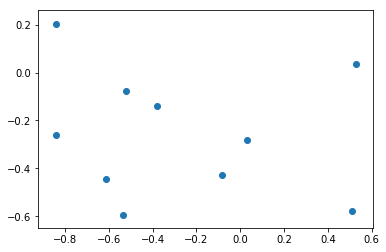

In [20]:
plt.scatter(x,y)

In [21]:
num_ratings_vs_movies = [0 for i in movie_dic.keys()]
for (i, j, yij) in lst:
    num_ratings_vs_movies[j] += 1
num_ratings_vs_movies = np.array(num_ratings_vs_movies)

In [22]:
indices = num_ratings_vs_movies.argsort()[-10:][::-1]

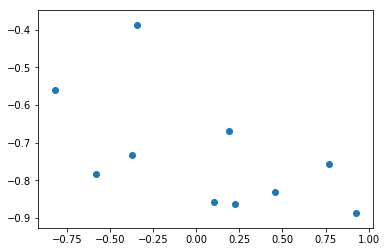

In [23]:
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

In [24]:
movie_rating_dic = {id: [] for id in movie_dic.keys()} # dic of movie id and ratings

for rating in lst:
    _, movie_id, r = rating
    movie_rating_dic[movie_id].append(r)

avg_ratings = {movie: sum(movie_rating_dic[movie]) / len(movie_rating_dic[movie]) \
               for movie in movie_rating_dic}

# get ten best movies that received highest average rating
top_10 = sorted(avg_ratings.items(), key=lambda tup: tup[1], reverse=True)[:10]
indices = [t[0] for t in top_10]

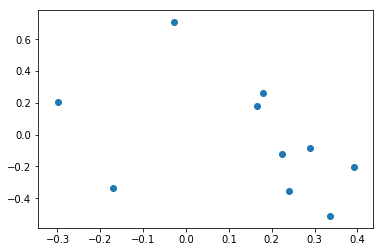

In [25]:
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

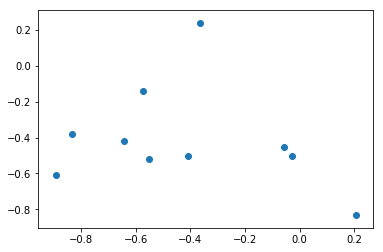

In [26]:
fant_movies = movie_genre_dic['Fantasy']
indices = fant_movies[:10]
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

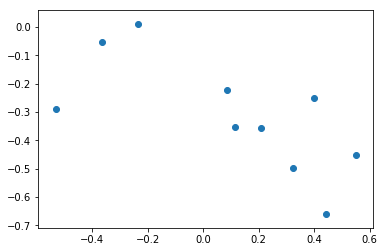

In [27]:
fant_movies = movie_genre_dic['Documentary']
indices = fant_movies[:10]
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)

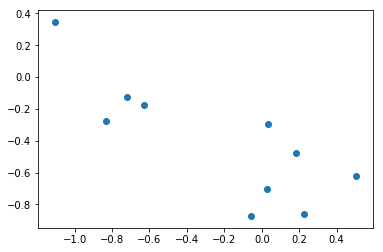

In [28]:
fant_movies = movie_genre_dic["Children's"]
indices = fant_movies[:10]
x = [transformed_v[i][0] for i in indices]
y = [transformed_v[i][1] for i in indices]
plt.scatter(x,y)